# Face Detection using Cascade Classifier

## Description
Face Detection is a computer vision problem that aims to attempt to accurately identify human faces that may, or may not, be present in a given photograph or video. Many efforts have been directed at this problem since the early 2000's, with it having started as a subbranch of the problem of Object-Class Detection but having evolved into a main focus of machine learning algorithms due to its prevalence and paramountcy to the paradigm of Facial Recognition, another problem that is nowadays used in a wide-branch of technologies and biometrics.

## Face Detection Function

### Imports

In [1]:
import cv2
import os
from os import listdir
from os.path import isfile, join
import time
from matplotlib import pyplot as plt

### Initialize Cascade Classifier

In [2]:
def initCascade(path):
    cascadeClassifier = cv2.CascadeClassifier()
    
    # Try to load the model
    if not cascadeClassifier.load(cv2.samples.findFile(path)):
        print("Error - Unable to load classifier")
        exit(0)
    
    return cascadeClassifier

### Detect Faces

In [3]:
def detectFaces(classifier, imgPath, scaleFactor = 1.1, minNeighbors = 3):
    img = cv2.imread(imgPath)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Get the Faces
    faces = classifier.detectMultiScale(
        img,
        scaleFactor,
        minNeighbors,
    )
    
    #print(faces)
    
    return faces

### Draw Boxes

In [4]:
def drawBoxes(imgPath, rects):
    img = cv2.imread(imgPath)

    # Draw the bounding boxes
    for (x,y,w,h) in faces:
        cv2.rectangle(img, (x,y), (x+w, y+h), (0,0,255), 3)
    
    cv2.imshow("Detected Faces", img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

### Write Results

In [5]:
def writeResults(path, faces, filename):
    with open("./CascadeClassifier/pred/"+filename, "a") as writer:
        #print("Writing results for image " + path.split("/")[1])
        writer.write(path.split("/")[-1].rstrip()+"\n")
        writer.write(str(len(faces))+"\n")
        
        for (x,y,w,h) in faces:
            faceCoords = str(x)+" "+str(y)+" "+str(w)+" "+str(h)
            
            writer.write(faceCoords+"\n")
        

### Compare Results

In [6]:
def compare_results(results_file, expected_file):
    image_faces = {}
    
    with open(expected_file, "r") as reader:
        while True:
            image_dir = reader.readline()
            if not image_dir: 
                break
            image_faces[image_dir] = []
            num_faces = int(reader.readline())
            for i in range(num_faces):
                image_faces[image_dir].append([int(elem) for elem in reader.readline().rstrip().split()])
                
    true_pos = 0
    false_pos = 0
    false_neg = 0
    with open(results_file, "r") as reader:
        while True:
            image_dir = reader.readline()
            
            if not image_dir:
                return true_pos, false_pos, false_neg
            
            expected_images = image_faces[image_dir]
            num_found_faces = int(reader.readline())
            
            for i in range(num_found_faces):
                start_x, start_y, width, height = [int(elem) for elem in reader.readline().split()]
                ## In order to be recognized as a face, it has to be within bounds, therfore
                compatible_index = -1
                
                for i in range(len(expected_images)):
                    expected_face = expected_images[i]
                    if start_x > expected_face[0] - 5 and start_y > expected_face[1] - 5 \
                    and start_x + width < expected_face[2] + 5 and start_y < expected_face[3] + 5:
                        compatible_index = i
                        break
                        
                if compatible_index != -1:
                    true_pos += 1
                    expected_images.pop(compatible_index)
                else:
                    false_pos += 1

            false_neg += len(expected_images)

### Compare Binary

In [7]:
def compare_bin_results(img_dir, results):
    true_pos = 0
    true_neg = 0
    false_pos = 0
    false_neg = 0
    with open(results, "r") as reader:
        while True:
            image = reader.readline().rstrip()
            if not image:
                return true_pos, true_neg, false_pos, false_neg
            num_found_faces = int(reader.readline())
            if num_found_faces == 0:
                if image[0:3] == "Pos": 
                    false_neg += 1
                else:
                    true_neg += 1
            for i in range(num_found_faces):
                start_x, start_y, width, height = [int(elem) for elem in reader.readline().split()]
                if image[0:3] == "Pos": #It's a positive image, we check if width and height are closer to the image
                    true_pos += 1
                    #real_height, real_width, _ = cv2.imread(img_dir + image).shape
                    #if abs(real_width - width) < 0.25*real_width and abs(real_height - height) < 0.25*real_height:
                    #    true_pos += 1
                    #else:
                    #    false_pos += 1
                else:
                    false_pos += 1

## Pretrained Model - haarcascade_frontalface_default.xml

In this section we will be using one of OpenCV's pretrained models for cascade classifier face detection.

In [25]:
#classifier = initCascade("./CascadeClassifier/haarcascade_frontalface_default.xml")
classifier = initCascade("./CascadeClassifier/haarcascade_frontalface_default.xml")

#Get values for a specific image
path = "./ImageResources/Dataset/WIDER_train/images/0--Parade/0_Parade_Parade_0_178.jpg"
path2 = "./ImageResources/Dataset/WIDER_train/images/4--Dancing/4_Dancing_Dancing_4_138.jpg"
path3 = "./dg.jpg"


faces = detectFaces(classifier, path3,  minNeighbors = 6)
drawBoxes(path3, faces)


### Default Values

In [11]:
# Get values for our Test Set

path = "./ImageResources/Dataset/WIDER_test/images"

classifier = initCascade("./CascadeClassifier/haarcascade_frontalface_default.xml")

results = open("./CascadeClassifier/pred/noTrain.txt", "w")
results.close()

list_imgs = [join(path, f) for f in listdir(path) if isfile(join(path, f))]

start = time.time()
for img in list_imgs:
    
    faces = detectFaces(classifier, img)
    writeResults(img,faces, "noTrain.txt")
    
end = time.time()
print("It took " + str(end - start) + " to finish results for the pretrained model stages")

answers = "./ImageResources/Dataset/WIDER_test/test.txt"
tp_d, fp_d, fn_d = compare_results("./CascadeClassifier/pred/noTrain.txt", answers)
print("Correctly found", tp_d)
print("Incorrectly found", fp_d)
print("Could not find", fn_d)

It took 104.62989473342896 to finish results for the pretrained model stages
Correctly found 1252
Incorrectly found 3607
Could not find 18753


NameError: name 'compare_results_binary' is not defined

In [15]:
path = "./ImageResources/Dataset/WIDER_test/cropped_images"

classifier = initCascade("./CascadeClassifier/haarcascade_frontalface_default.xml")

results = open("./CascadeClassifier/pred/noTrainBin.txt", "w")
results.close()

list_imgs = [join(path, f) for f in listdir(path) if isfile(join(path, f))]

start = time.time()
for img in list_imgs:
    
    faces = detectFaces(classifier, img)
    writeResults(img,faces, "noTrainBin.txt")
    
end = time.time()
print("It took " + str(end - start) + " to finish results for the pretrained model stages")

tp_d2, tn_d2, fp_d2, fn_d2 = compare_bin_results(path, "./CascadeClassifier/pred/noTrainBin.txt")
print("Correctly found", tp_d2)
print("Correctly not found", tn_d2)
print("Incorrectly found", fp_d2)
print("Could not find", fn_d2)

It took 117.37798118591309 to finish results for the pretrained model stages
Correctly found 835
Correctly not found 9790
Incorrectly found 249
Could not find 9194


### Changing Neighbors

In [8]:
path = "./ImageResources/Dataset/WIDER_test/images"
answers = "./ImageResources/Dataset/WIDER_test/test.txt"
bin_path = "./ImageResources/Dataset/WIDER_test/cropped_images"

tp_arr = []
fp_arr = []
fn_arr = []

tp_arr_b = []
tn_arr_b = []
fp_arr_b = []
fn_arr_b = []

acc_arr = []
recall_arr = []

acc_arr_b = []
recall_arr_b = []

for neighbours in range(1,10):
    classifier = initCascade("./CascadeClassifier/haarcascade_frontalface_default.xml")
    
    results = open("./CascadeClassifier/pred/noTrain.txt", "w")
    results.close()

    list_imgs = [join(path, f) for f in listdir(path) if isfile(join(path, f))]

    start = time.time()
    for img in list_imgs:

        faces = detectFaces(classifier, img, minNeighbors=neighbours)
        writeResults(img,faces, "noTrain.txt")

    end = time.time()
    print("It took " + str(end - start) + " to finish results for the pretrained model stages")
    
    tp, fp, fn = compare_results("./CascadeClassifier/pred/noTrain.txt", answers)
    
    tp_arr.append(tp)
    fp_arr.append(fp)
    fn_arr.append(fn)
    
    results = open("./CascadeClassifier/pred/noTrainBin.txt", "w")
    results.close()

    list_imgs = [join(bin_path, f) for f in listdir(bin_path) if isfile(join(bin_path, f))]

    start = time.time()
    for img in list_imgs:

        faces = detectFaces(classifier, img, minNeighbors=neighbours)
        writeResults(img,faces, "noTrainBin.txt")

    end = time.time()
    print("It took " + str(end - start) + " to finish results for the pretrained model stages")

    tp, tn, fp, fn = compare_bin_results(path, "./CascadeClassifier/pred/noTrainBin.txt")
    
    tp_arr_b.append(tp)
    tn_arr_b.append(tn)
    fp_arr_b.append(fp)
    fn_arr_b.append(fn)



It took 129.7256646156311 to finish results for the pretrained model stages
It took 137.95983815193176 to finish results for the pretrained model stages
It took 157.30901551246643 to finish results for the pretrained model stages
It took 161.6300950050354 to finish results for the pretrained model stages
It took 143.19811415672302 to finish results for the pretrained model stages
It took 165.48867392539978 to finish results for the pretrained model stages
It took 167.16038346290588 to finish results for the pretrained model stages
It took 167.54135036468506 to finish results for the pretrained model stages
It took 160.36675810813904 to finish results for the pretrained model stages


[1877, 1191, 835, 636, 509, 395, 316, 261, 222]
[8987, 9561, 9790, 9882, 9920, 9945, 9960, 9975, 9984]
[1486, 550, 249, 132, 87, 58, 43, 26, 17]
[8303, 8880, 9194, 9377, 9494, 9603, 9680, 9735, 9774]


ValueError: x and y must have same first dimension, but have shapes (9,) and (0,)

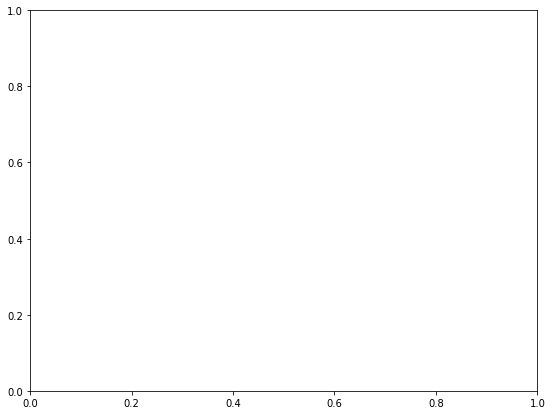

In [9]:

print(tp_arr_b)
print(tn_arr_b)
print(fp_arr_b)
print(fn_arr_b)


plt.figure(figsize = (20,7))
plt.subplot(1,2,1)
plt.plot(range(1,10), tp_arr, color="#e33641")
plt.xlabel('minNeighbors')
plt.ylabel('True Positives')
plt.title('True positives in function of the number of minimum required neighbours',fontsize=15)

plt.subplot(1,2,2)
plt.plot(range(1,10), fp_arr, color="#731f58")
plt.xlabel('minNeighbors')
plt.ylabel('False Positives')
plt.title('False Positives in function of the number of minimum required neighbours',fontsize=15)
plt.show()

plt.plot(range(1,10), fn_arr, color="#2a8281")
plt.xlabel('minNeighbors')
plt.ylabel('False Negatives')
plt.title('False Negatives in function of the number of minimum required neighbours',fontsize=15)

plt.show()

### Changing Scale Factor

In [9]:
path = "./ImageResources/Dataset/WIDER_test/images"
answers = "./ImageResources/Dataset/WIDER_test/test.txt"
bin_path = "./ImageResources/Dataset/WIDER_test/cropped_images"

tp_arr2 = []
fp_arr2 = []
fn_arr2 = []

acc_arr2 = []
recall_arr2 = []

tp_arr2_b = []
tn_arr2_b = []
fp_arr2_b = []
fn_arr2_b = []

acc_arr2_b = []
recall_arr2_b = []

neighbours = 6 #Substitute for optimal number of neighbours
for scale_factor in [1.05, 1.10, 1.15, 1.20, 1.25]:
    classifier = initCascade("./CascadeClassifier/haarcascade_frontalface_default.xml")
    
    results = open("./CascadeClassifier/pred/noTrain.txt", "w")
    results.close()

    list_imgs = [join(path, f) for f in listdir(path) if isfile(join(path, f))]

    start = time.time()
    for img in list_imgs:

        faces = detectFaces(classifier, img, scaleFactor=scale_factor)
        writeResults(img,faces, "noTrain.txt")

    end = time.time()
    print("It took " + str(end - start) + " to finish results for the pretrained model stages")
    
    tp, fp, fn = compare_results("./CascadeClassifier/pred/noTrain.txt", answers)
    
    tp_arr2.append(tp)
    fp_arr2.append(fp)
    fn_arr2.append(fn)
    
    results = open("./CascadeClassifier/pred/noTrainBin.txt", "w")
    results.close()

    list_imgs = [join(bin_path, f) for f in listdir(bin_path) if isfile(join(bin_path, f))]

    start = time.time()
    for img in list_imgs:

        faces = detectFaces(classifier, img, scaleFactor=scale_factor)
        writeResults(img,faces, "noTrainBin.txt")

    end = time.time()
    print("It took " + str(end - start) + " to finish results for the pretrained model stages")

    tp, tn, fp, fn = compare_bin_results(path, "./CascadeClassifier/pred/noTrainBin.txt")
    
    tp_arr2_b.append(tp)
    tn_arr2_b.append(tn)
    fp_arr2_b.append(fp)
    fn_arr2_b.append(fn)

It took 275.0609700679779 to finish results for the pretrained model stages
It took 294.1935043334961 to finish results for the pretrained model stages
It took 141.47845935821533 to finish results for the pretrained model stages
It took 140.34717273712158 to finish results for the pretrained model stages
It took 110.81240773200989 to finish results for the pretrained model stages
It took 114.43330097198486 to finish results for the pretrained model stages
It took 92.18318510055542 to finish results for the pretrained model stages
It took 95.70916318893433 to finish results for the pretrained model stages
It took 71.63717126846313 to finish results for the pretrained model stages
It took 76.51829719543457 to finish results for the pretrained model stages


true positives, complex test [1471, 1252, 1030, 931, 823]
false positives, complex test [6434, 3607, 2867, 2337, 1801]
false negatives, complex test [18534, 18753, 18975, 19074, 19182]
true positives, simple test [1609, 835, 624, 468, 274]
true negatives, simple test [9379, 9790, 9875, 9920, 9961]
false positives, simple test [817, 249, 142, 89, 41]
false negatives, simple test [8516, 9194, 9387, 9535, 9724]


ValueError: x and y must have same first dimension, but have shapes (6,) and (5,)

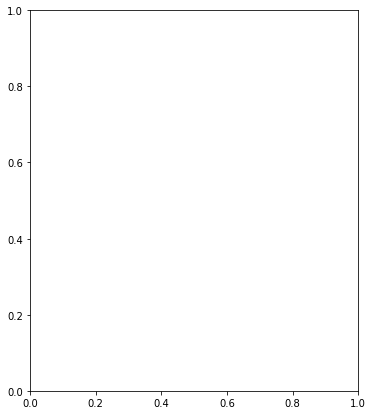

In [11]:
print("true positives, complex test", tp_arr2)
print("false positives, complex test", fp_arr2)
print("false negatives, complex test",fn_arr2)

print("true positives, simple test",tp_arr2_b)
print("true negatives, simple test",tn_arr2_b)
print("false positives, simple test",fp_arr2_b)
print("false negatives, simple test",fn_arr2_b)

plt.figure(figsize = (20,7))
plt.subplot(1,3,1)
plt.plot([0.95, 1, 1.05, 1.10, 1.15, 1.20], tp_arr2, color="#e33641")
plt.xlabel('scaleFactor')
plt.ylabel('True Positives')
plt.title('True positives in function of the scale factor',fontsize=15)

plt.subplot(1,3,2)
plt.plot([0.95, 1, 1.05, 1.10, 1.15, 1.20], fp_arr2, color="#731f58")
plt.xlabel('scaleFactor')
plt.ylabel('False Positives')
plt.title('False Positives in function of the scale factor',fontsize=15)

plt.subplot(1,3,3)
plt.plot([0.95, 1, 1.05, 1.10, 1.15, 1.20], fn_arr2, color="#2a8281")
plt.xlabel('scaleFactor')
plt.ylabel('False Negatives')
plt.title('False Negatives in function of the scale factor',fontsize=15)

plt.show()

plt.figure(figsize = (20,7))
plt.subplot(1,2,1)
plt.plot([0.95, 1, 1.05, 1.10, 1.15, 1.20], acc_arr2, color="#e33641")
plt.xlabel('scaleFactor')
plt.ylabel('Accuracy')
plt.title('Accuracy in function of the number of minimum required neighbours',fontsize=15)

plt.subplot(1,2,2)
plt.plot([0.95, 1, 1.05, 1.10, 1.15, 1.20], recall_arr2, color="#731f58")
plt.xlabel('scaleFactor')
plt.ylabel('Recall')
plt.title('Recall in function of the number of minimum required neighbours',fontsize=15)

plt.show()

## Train Model

First you have to run the following command:
```
opencv_createsamples -info ../ImageResources/Dataset/WIDER_train/cropped_images/positive_info.dat -num 10000 -w 32 -h 32 -vec faces.vec
```
Where positive_info.dat should be a file containing all positive images, how many faces there in each image and their bounding boxes in the following format:
```
image_path no_faces x y width height
```

To train the classifier we need to run the following command:
```
opencv_traincascade -data model -vec faces.vec -bg negative_info.txt -numPos 2500 -numNeg 2500 -numStages 1 -w 32 -h 32 
```

Where model is a folder that we should create beforehand in which the model will be stored

_minHitRate <min_hit_rate>_ : Minimal desired hit rate for each stage of the classifier. Overall hit rate may be estimated as (min_hit_rate ^ number_of_stages), [245] §4.1.

_maxFalseAlarmRate <max_false_alarm_rate>_ : Maximal desired false alarm rate for each stage of the classifier. Overall false alarm rate may be estimated as (max_false_alarm_rate ^ number_of_stages), [245] §4.1.

_weightTrimRate <weight_trim_rate>_ : Specifies whether trimming should be used and its weight. A decent choice is 0.95.

_maxDepth <max_depth_of_weak_tree>_ : Maximal depth of a weak tree. A decent choice is 1, that is case of stumps.

_maxWeakCount <max_weak_tree_count>_ : Maximal count of weak trees for every cascade stage. The boosted classifier (stage) will have so many weak trees (<=maxWeakCount), as needed to achieve the given -maxFalseAlarmRate.

## Use Trained Model

### Changing number of stages

In [12]:
#classifier = initCascade("./CascadeClassifier/models/model1stage/cascade.xml")
#classifier = initCascade("./CascadeClassifier/models/model5stages/cascade.xml")
classifier = initCascade("./CascadeClassifier/models/model0.9995hitrate/cascade.xml")

#Get values for a specific image
path = "./ImageResources/Dataset/WIDER_train/images/0--Parade/0_Parade_Parade_0_178.jpg"
path2 = "./ImageResources/Dataset/WIDER_train/images/4--Dancing/4_Dancing_Dancing_4_138.jpg"
path3 = "./dg.jpg"
path4= "./ImageResources/Dataset/WIDER_train/images/27--Spa/27_Spa_Spa_27_37.jpg"

print("detecting faces")
faces = detectFaces(classifier, path,  minNeighbors = 6)
print("finished detecting faces")

drawBoxes(path, faces)
print("finished showing image")

detecting faces
finished detecting faces
finished showing image


In [12]:
path = "./ImageResources/Dataset/wider_face_split/wider_face_val_bbx_gt.txt" #Path to the test images

print("Just one image")
times_single = []
for no_stages in ["5", "10", "15", "20", "25", "30", "35", "40"]:
    classifier = initCascade("./CascadeClassifier/models/model"+no_stages+"stages/cascade.xml")

    # Get values for our Test Set
    path = "./ImageResources/Dataset/WIDER_test/images"

    results = open("./CascadeClassifier/pred/"+no_stages+"stages.txt", "w")
    results.close()

    list_imgs = [join(path, f) for f in listdir(path) if isfile(join(path, f))]
    
    start = time.time()
    for img in list_imgs:
        faces = detectFaces(classifier, img)
        writeResults(img,faces, no_stages+"stages.txt")
        break
    end = time.time()
    
    times_single.append(end-start)
    
    print("It took " + str(end - start) + " to finish results for " + no_stages + "stages")


print("Multiple Images")
times_multi = []
for no_stages in ["10", "15", "20", "25", "30", "35", "40"]:
    classifier = initCascade("./CascadeClassifier/models/model"+no_stages+"stages/cascade.xml")

    # Get values for our Test Set
    path = "./ImageResources/Dataset/WIDER_test/images"

    results = open("./CascadeClassifier/pred/"+no_stages+"stages.txt", "w")
    results.close()

    list_imgs = [join(path, f) for f in listdir(path) if isfile(join(path, f))]
    
    start = time.time()
    for img in list_imgs:
        faces = detectFaces(classifier, img)
        writeResults(img,faces, no_stages+"stages.txt")
        break
    end = time.time()
    times_multi.append(end-start)
    
    print("It took " + str(end - start) + " to finish results for " + no_stages + "stages")

Just one image
It took 220.9446361064911 to finish results for 5stages
It took 5.287785053253174 to finish results for 10stages
It took 0.6900830268859863 to finish results for 15stages
It took 0.3858218193054199 to finish results for 20stages
It took 0.44898009300231934 to finish results for 25stages
It took 0.43389177322387695 to finish results for 30stages
It took 0.49165773391723633 to finish results for 35stages
It took 0.48737311363220215 to finish results for 40stages
Multiple Images
It took 5.442720413208008 to finish results for 10stages
It took 0.6984388828277588 to finish results for 15stages
It took 0.40036654472351074 to finish results for 20stages
It took 0.467670202255249 to finish results for 25stages
It took 0.43861818313598633 to finish results for 30stages
It took 0.4966905117034912 to finish results for 35stages
It took 0.439420223236084 to finish results for 40stages


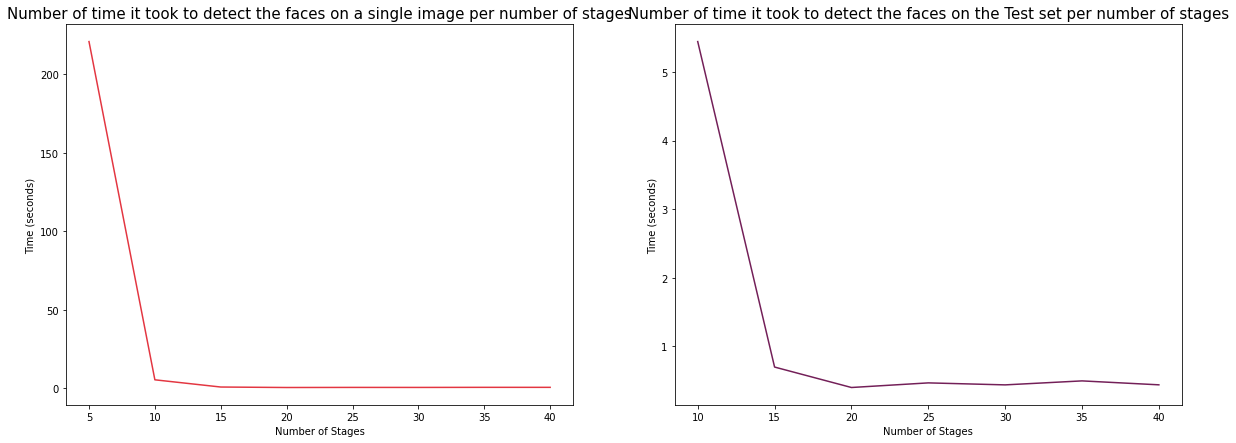

In [13]:
plt.figure(figsize = (20,7))
    
plt.subplot(1,2,1)
plt.plot(["5", "10", "15", "20", "25", "30", "35", "40"], times_single, color="#e33641")
plt.xlabel('Number of Stages')
plt.ylabel('Time (seconds)')
plt.title('Number of time it took to detect the faces on a single image per number of stages',fontsize=15)

plt.subplot(1,2,2)
plt.plot(["10", "15", "20", "25", "30", "35", "40"], times_multi, color="#731f58")
plt.xlabel('Number of Stages')
plt.ylabel('Time (seconds)')
plt.title('Number of time it took to detect the faces on the Test set per number of stages',fontsize=15)
plt.show()